In [1]:
import pandas as pd

# Load ground truth
ground_truth = pd.read_excel("ground_truth.xlsx")

# Load model outputs after manual mapping
mapped_chatgpt4 = pd.read_csv("mapped_chatgpt4.csv")
mapped_chatgpt4omini = pd.read_csv("mapped_chatgpt4omini.csv")
mapped_llama3 = pd.read_csv("mapped_llama3.csv")
mapped_dsv3 = pd.read_csv("mapped_dsv3.csv")

# Combine all attributes from ground truth and mapped model outputs
all_attributes = list(set(
    list(mapped_chatgpt4["Mapped Attribute"]) +
    list(mapped_chatgpt4omini["Mapped Attribute"]) +
    list(mapped_llama3["Mapped Attribute"]) +
    list(mapped_dsv3["Mapped Attribute"]) +
    list(ground_truth["Attribute"])
))

print(f"Total unique attributes: {len(all_attributes)}")


Total unique attributes: 2424


In [3]:
import openai
import numpy as np
import time

import yaml
# Load the configuration file for OpenAI API key
with open("config.yaml") as f:
    config_yaml = yaml.load(f, Loader=yaml.FullLoader)
openai.api_key = config_yaml['token']

# Function to generate embeddings using OpenAI API
def generate_embeddings(attributes, model="text-embedding-3-small"):
    embeddings = []
    for attribute in attributes:
        try:
            response = openai.Embedding.create(
                input=attribute,
                model=model
            )
            embeddings.append(response['data'][0]['embedding'])
        except Exception as e:
            print(f"Error generating embedding for '{attribute}': {e}")
            embeddings.append([None] * 1536)  # Placeholder for failed embeddings
        time.sleep(1)  # Avoid rate limits
    return np.array(embeddings)

# Generate embeddings for "text-embedding-3-small"
embeddings_small = generate_embeddings(all_attributes, model="text-embedding-3-small")
print(f"Embeddings generated for {len(embeddings_small)} attributes using text-embedding-3-small")

# Generate embeddings for "text-embedding-3-large"
embeddings_large = generate_embeddings(all_attributes, model="text-embedding-3-large")
print(f"Embeddings generated for {len(embeddings_large)} attributes using text-embedding-3-large")


Embeddings generated for 1962 attributes using text-embedding-3-small
Embeddings generated for 1962 attributes using text-embedding-3-large


In [4]:
# Save embeddings for text-embedding-3-small
np.save("embeddings_small.npy", embeddings_small)
pd.DataFrame(embeddings_small, index=all_attributes).to_csv("embeddings_small.csv")

# Save embeddings for text-embedding-3-large
np.save("embeddings_large.npy", embeddings_large)
pd.DataFrame(embeddings_large, index=all_attributes).to_csv("embeddings_large.csv")


In [5]:
# Load embeddings for verification
embeddings_small_loaded = np.load("embeddings_small.npy")
embeddings_large_loaded = np.load("embeddings_large.npy")

print(f"Shape of small embeddings: {embeddings_small_loaded.shape}")
print(f"Shape of large embeddings: {embeddings_large_loaded.shape}")


Shape of small embeddings: (1962, 1536)
Shape of large embeddings: (1962, 3072)


Refining Clustering with K-Means, DBSCAN, and Agglomerative Clustering

In [6]:
import numpy as np

# Load embeddings (use small embeddings as an example)
embeddings = np.load("embeddings_small.npy")

print(f"Embeddings Shape: {embeddings.shape}")


Embeddings Shape: (1962, 1536)


In [7]:
from sklearn.cluster import KMeans

# Set the number of clusters
num_clusters = 10  # You can tune this based on the Elbow Method or Silhouette Score

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

print(f"K-Means Clusters: {len(set(kmeans_labels))}")


K-Means Clusters: 10


In [8]:
from sklearn.cluster import DBSCAN

# Set DBSCAN parameters
eps = 0.5  # Radius of neighborhood
min_samples = 5  # Minimum samples in a neighborhood to form a cluster

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(embeddings)

print(f"DBSCAN Clusters: {len(set(dbscan_labels))} (including noise as -1)")


DBSCAN Clusters: 4 (including noise as -1)


In [9]:
from sklearn.cluster import AgglomerativeClustering

# Set the number of clusters
num_clusters = 10  # Tune this based on your evaluation

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
agg_labels = agg_clustering.fit_predict(embeddings)

print(f"Agglomerative Clusters: {len(set(agg_labels))}")


Agglomerative Clusters: 10


In [10]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
silhouette_kmeans = silhouette_score(embeddings, kmeans_labels)
silhouette_dbscan = silhouette_score(embeddings, dbscan_labels, metric="euclidean") if len(set(dbscan_labels)) > 1 else -1
silhouette_agg = silhouette_score(embeddings, agg_labels)

print(f"Silhouette Score (K-Means): {silhouette_kmeans:.2f}")
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan:.2f}")
print(f"Silhouette Score (Agglomerative): {silhouette_agg:.2f}")


Silhouette Score (K-Means): 0.04
Silhouette Score (DBSCAN): -0.03
Silhouette Score (Agglomerative): 0.00


In [11]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index
dbi_kmeans = davies_bouldin_score(embeddings, kmeans_labels)
dbi_dbscan = davies_bouldin_score(embeddings, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
dbi_agg = davies_bouldin_score(embeddings, agg_labels)

print(f"Davies-Bouldin Index (K-Means): {dbi_kmeans:.2f}")
print(f"Davies-Bouldin Index (DBSCAN): {dbi_dbscan:.2f}")
print(f"Davies-Bouldin Index (Agglomerative): {dbi_agg:.2f}")


Davies-Bouldin Index (K-Means): 4.28
Davies-Bouldin Index (DBSCAN): 1.49
Davies-Bouldin Index (Agglomerative): 4.94


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


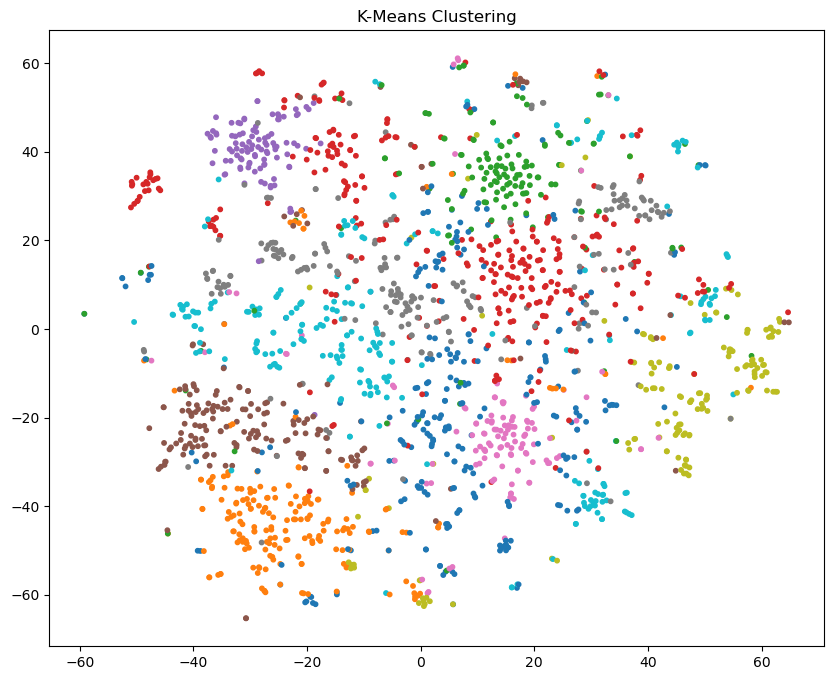

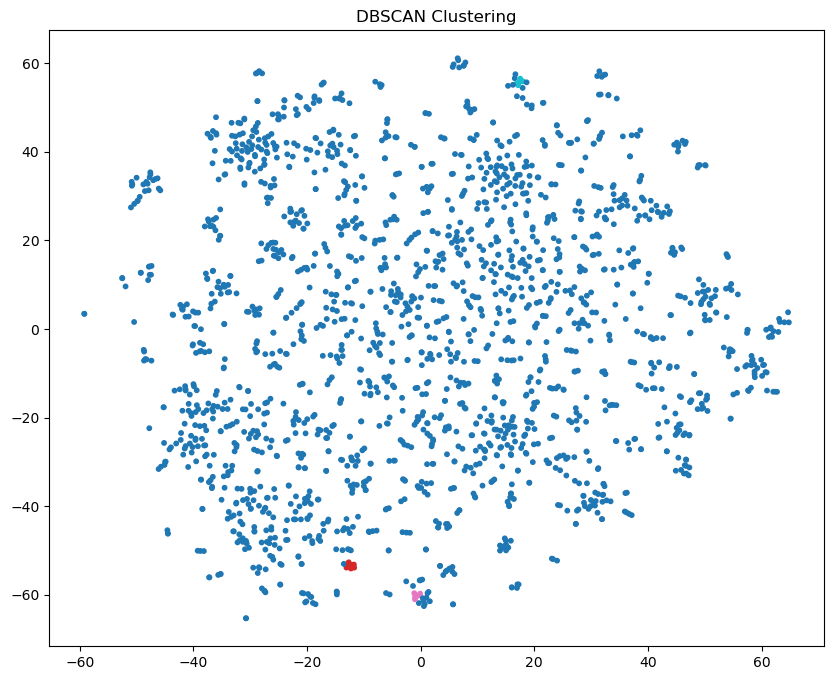

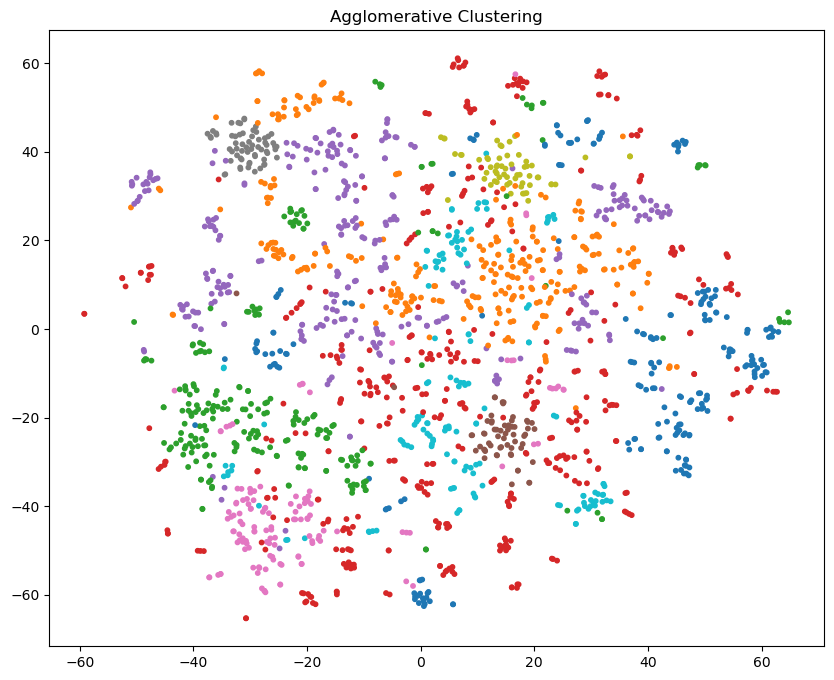

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot clusters for K-Means
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans_labels, cmap='tab10', s=10)
plt.title('K-Means Clustering')
plt.show()

# Plot clusters for DBSCAN
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='tab10', s=10)
plt.title('DBSCAN Clustering')
plt.show()

# Plot clusters for Agglomerative Clustering
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=agg_labels, cmap='tab10', s=10)
plt.title('Agglomerative Clustering')
plt.show()


In [13]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# K-Means
silhouette_kmeans = silhouette_score(embeddings, kmeans_labels)
dbi_kmeans = davies_bouldin_score(embeddings, kmeans_labels)

# DBSCAN
silhouette_dbscan = silhouette_score(embeddings, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
dbi_dbscan = davies_bouldin_score(embeddings, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Agglomerative Clustering
silhouette_agg = silhouette_score(embeddings, agg_labels)
dbi_agg = davies_bouldin_score(embeddings, agg_labels)

# Print results
print(f"Silhouette Score (K-Means): {silhouette_kmeans:.2f}")
print(f"Davies-Bouldin Index (K-Means): {dbi_kmeans:.2f}")
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan:.2f}")
print(f"Davies-Bouldin Index (DBSCAN): {dbi_dbscan:.2f}")
print(f"Silhouette Score (Agglomerative): {silhouette_agg:.2f}")
print(f"Davies-Bouldin Index (Agglomerative): {dbi_agg:.2f}")

Silhouette Score (K-Means): 0.04
Davies-Bouldin Index (K-Means): 4.28
Silhouette Score (DBSCAN): -0.03
Davies-Bouldin Index (DBSCAN): 1.49
Silhouette Score (Agglomerative): 0.00
Davies-Bouldin Index (Agglomerative): 4.94


Improve Clustering

Fine-Tuning